In [1]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
import pandas as pd
pd.__version__

'0.24.2'

In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [5]:
# dataset path
dataset_path = './csv/diff_dataset.csv'
testset_path = './csv/diff_testset.csv'

In [6]:
# read dataset
dataset = pd.read_csv(dataset_path, index_col=None, header=0)
testset = pd.read_csv(testset_path, index_col=None, header=0)

In [7]:
# Delete the following states
# 0: ixnetwork-traffic-start
# 2: node-up
# 4: interface-up
# 6: tap-loss-stop
# 8: tap-delay-stop
# 10: ixnetwork-bgp-injection-stop
# 12: ixnetwork-bgp-hijacking-stop
data_drop_index = dataset[dataset['v_type_code'] % 2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] % 2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)

print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

dataset:
(930, 998)
testset:
(840, 998)


# Remove Nan

In [8]:
# dataset.dropna(axis=1, how='any', inplace=True)
# testset.dropna(axis=1, how='any', inplace=True)
# print('dataset:')
# print(dataset.shape)
# print('testset:')
# print(testset.shape)

# Split dataset

In [9]:
# train test split
column = dataset.columns
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 997) (1770,)
(930, 997) (930,)
(840, 997) (840,)


# Standard input value  （only SVM and MLP）

In [10]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)
# X_train = dataset[column[:-1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) - np.min(x) != 0 else 0)
# X_test = testset[column[:-1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) - np.min(x) != 0 else 0)

In [11]:
#准确率会降到20%
#std_X = ss.fit_transform(X)

# label one hot

In [12]:
# Y_1 = pd.get_dummies(Y, prefix='type')
# Y_1[:100]
#Y_1=Y_1.values

In [13]:
# y_train_1 = pd.get_dummies(y_train, prefix='type')
# y_test_1 = pd.get_dummies(y_test, prefix='type')
# y_train_1.head()

# XGBoost model

In [14]:
def xgboost(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=estimators, n_jobs=-1, objective='multi:softmax', num_class=5, random_state=0)

    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    print("n_estimators: %d" % estimators)
    print("XGBOOST Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix xgb:')
        print(cm)
        print('classification report xgb:')
        print(classification_report(y_test, y_pred))

# Decision Tree

In [15]:
def decision_tree(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

    dt.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = dt.predict(X_test)

    current_time = time.time()

    print("DT Accuracy: %.2f" % accuracy_score(y_test, y_pred))

    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix dt:')
        print(cm)
        print('classification report dt:')
        print(classification_report(y_test, y_pred))

# Random Forest

In [16]:
def random_forest(X_train, y_train, X_test, y_test, show=False, estimators=100):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=estimators, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()
    print("n_estimators: %d" % estimators)
    print("RF Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))
    
    return rf


# MLP

In [17]:
def mlp(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    mlp = MLPClassifier(solver='sgd', activation='relu', alpha=1e-4, hidden_layer_sizes=(200, 200, 200, 200),
                        random_state=1, max_iter=10000, verbose=0, learning_rate_init=.1)
    mlp.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = mlp.predict(std_X_test)
    current_time = time.time()
    print("MLP Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix MLP:')
        print(cm)
        print('classification report MLP:')
        print(classification_report(y_test, y_pred))

# SVM

In [18]:
def svm_cross_validation(X, y):
    model = svm.SVC(kernel='rbf', probability=True)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_parameters = grid_search.best_estimator_.get_params()
    for para, val in list(best_parameters.items()):
        print(para, val)
    model = svm.SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
    model.fit(X, y)
    return model


def train_svm(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    # model = svm_cross_validation(std_X_train, y_train.ravel())
    model = svm.SVC(kernel='rbf', C=10, gamma=0.001, probability=True)
    model.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = model.predict(std_X_test)
    print("SVM Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    current_time = time.time()
    print("train time： {}".format(middle_time - last_time))
    if show:
        print("test time： {}".format(current_time - middle_time))
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix svm:')
        print(cm)
        print('classification report svm:')
        print(classification_report(y_test, y_pred))

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
# one hot label DT
# decision_tree(X_train, y_train_1, X_test, y_test_1)

In [21]:
# DT result
decision_tree(X_train, y_train, X_test, y_test, show=True)

DT Accuracy: 0.81
train time： 0.3844008445739746
test time： 0.009289264678955078
confusion matrix dt:
[[ 55   8   0   0   1]
 [  0  64   0   1   7]
 [  0   0 156   0   0]
 [  0   3   0 137  40]
 [  0   3   0  97 268]]
classification report dt:
              precision    recall  f1-score   support

           1       1.00      0.86      0.92        64
           3       0.82      0.89      0.85        72
           9       1.00      1.00      1.00       156
          11       0.58      0.76      0.66       180
          57       0.85      0.73      0.78       368

    accuracy                           0.81       840
   macro avg       0.85      0.85      0.84       840
weighted avg       0.83      0.81      0.81       840



In [22]:
# one hot label RF
# random_forest(X_train, y_train_1, X_test, y_test_1)

In [23]:
# RF result
rf = random_forest(X_train, y_train, X_test, y_test, show=True)

n_estimators: 100
RF Accuracy: 0.93
train time： 0.8479940891265869
test time： 0.024599075317382812
confusion matrix rf:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   0   0 130  50]
 [  0   2   0   9 357]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.97      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.94      0.72      0.82       180
          57       0.88      0.97      0.92       368

    accuracy                           0.93       840
   macro avg       0.96      0.94      0.94       840
weighted avg       0.93      0.93      0.92       840



In [24]:
# pip install graphviz

In [29]:
# 提取一个决策树
estimator = rf.estimators_[5]

from sklearn.tree import export_graphviz
# 导出为dot 文件
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = column[:-1],
                class_names = ['1', '3', '9', '11', '57'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# 用系统命令转为PNG文件(需要 Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [30]:
# 在jupyter notebook中展示
# from IPython.display import Image
# Image(filename = 'tree.png')

In [67]:
# one hot label mlp
# mlp(std_X_train, y_train_1, std_X_test, y_test_1)

MLP Accuracy: 0.57
train time： 10.232213973999023
test time： 0.03972005844116211
confusion matrix MLP:
[[ 54   2   4   4   0   0]
 [  0  42  12  10   8   0]
 [  0   4  95  78  12   0]
 [  0   0  57  98  24   0]
 [  0   4  32  41  76   3]
 [  0   1  26  25  16 112]]
classification report MLP:
              precision    recall  f1-score   support

           1       1.00      0.84      0.92        64
           3       0.79      0.58      0.67        72
           5       0.42      0.50      0.46       189
           7       0.38      0.55      0.45       179
           9       0.56      0.49      0.52       156
          11       0.97      0.62      0.76       180

    accuracy                           0.57       840
   macro avg       0.69      0.60      0.63       840
weighted avg       0.63      0.57      0.59       840

Normalized confusion matrix
[[0.84375    0.03125    0.0625     0.0625     0.         0.        ]
 [0.         0.58333333 0.16666667 0.13888889 0.11111111 0.        

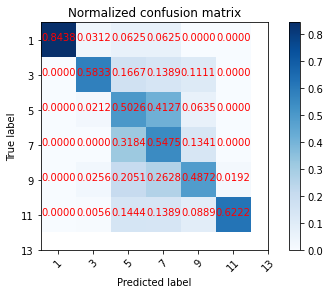

In [119]:
# mlp reulst
mlp(std_X_train, y_train, std_X_test, y_test, show=True)

In [69]:
# one hot label svm
# 报错 稍后看 DataFrame' object has no attribute 'ravel'
# train_svm(std_X_train, y_train_1, std_X_test, y_test_1)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 10.0min finished


C 10
break_ties False
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 3
gamma 0.001
kernel rbf
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False
SVM Accuracy: 0.56
train time： 630.11328291893
test time： 1.7879009246826172
confusion matrix svm:
[[ 63   0   0   1   0   0]
 [  1  44   4  17   6   0]
 [  0   1  92  90   6   0]
 [  0   1  40 120  18   0]
 [  1   0  24  56  75   0]
 [  0   2  53  31  15  79]]
classification report svm:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98        64
           3       0.92      0.61      0.73        72
           5       0.43      0.49      0.46       189
           7       0.38      0.67      0.49       179
           9       0.62      0.48      0.54       156
          11       1.00      0.44      0.61       180

    accuracy                           0.56       840
   macro avg       0.72      0.61      0.63       840
weighted avg

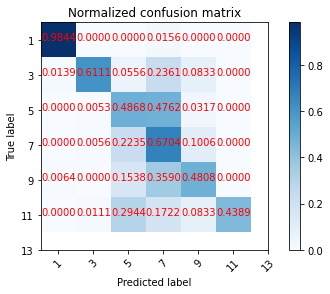

In [120]:
# svm result
train_svm(std_X_train, y_train, std_X_test, y_test, show=True)

Accuracy: 0.74
train time： 42.46573209762573
test time： 0.11216592788696289
confusion matrix xgb:
[[ 60   3   1   0   0   0]
 [  0  46  15   9   2   0]
 [  0   1 141  46   0   1]
 [  0   0  73 104   1   1]
 [  0   0   1   0 155   0]
 [  0   0  25  38   1 116]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        64
           3       0.92      0.64      0.75        72
           5       0.55      0.75      0.63       189
           7       0.53      0.58      0.55       179
           9       0.97      0.99      0.98       156
          11       0.98      0.64      0.78       180

    accuracy                           0.74       840
   macro avg       0.83      0.76      0.78       840
weighted avg       0.78      0.74      0.75       840

Normalized confusion matrix
[[0.9375     0.046875   0.015625   0.         0.         0.        ]
 [0.         0.63888889 0.20833333 0.125      0.02777778 0.        ]
 [0

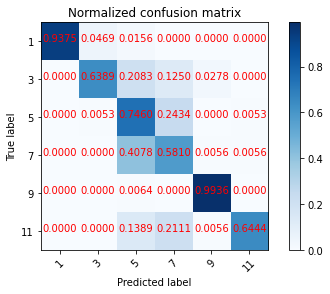

In [121]:
# show xgboost result
xgboost(X_train, y_train, X_test, y_test,show=True)

# Analysis By three types file

In [122]:
X_train_n = X_train[X_train.columns[:269]]
X_test_n = X_test[X_test.columns[:269]]
X_train_n.head()

,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/local_gb_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/current_workload,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,...,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/early-drop-pkts,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/early-drop-bytes,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/mean-queue-depth,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/transmitted-pkts,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/transmitted-bytes,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/tail-drop-pkts,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/tail-drop-bytes,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/drop-pkts-flow,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/drop-pkts-no-buffer,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/queue-peak-size-pkts
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
X_train_p = X_train[X_train.columns[269:412]]
X_test_p = X_test[X_test.columns[269:412]]
X_train_p.head()

,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/queue-peak-size-bytes,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/wred-stats/bandwidth-exceed-drops,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/cac-stats/num-admitted-flows,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/cac-stats/num-non-admitted-flows,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/marking-stats/marking-dscp-stats-val/dscp,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/marking-stats/marking-dscp-stats-val/marked-pkts,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/marking-stats/marking-dscp-tunnel-stats-val/dscp-val,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/marking-stats/marking-dscp-tunnel-stats-val/marked-pkts,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/marking-stats/marking-cos-stats-val/cos-val,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/marking-stats/marking-cos-stats-val/marked-pkts,...,n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/q-filesystem/chassisnum,n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/q-filesystem/partitions/total-size,n_/devices/modules/Cisco-IOS-XE-platform-software-oper/cisco-platform-software/q-filesystem/partitions/used-size,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/total-memory,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/free-memory,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/lowest-usage,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/highest-usage,n_nexthop,n_prefix
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1244104.0,-1244104.0,0.0,0.0,-4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4096.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-776.0,776.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4096.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4096.0,0.0,-996.0,996.0,0.0,0.0,0.0,0.0


In [124]:
X_train_v = X_train[X_train.columns[412:]]
X_test_v = X_test[X_test.columns[412:]]
X_train_v.head()

,v_/devices#IntGW-01/flavor/ram,v_/devices#IntGW-01/flavor/vcpus,v_/devices#IntGW-01/flavor/disk,v_/devices#IntGW-01/image/min_ram,v_/devices#IntGW-01/image/min_disk,v_/devices#IntGW-01/image/size,v_/devices#IntGW-01/image/metrics/image-size,v_/devices#IntGW-01/power_state,v_/devices#IntGW-01/metrics/disk-device-allocation,v_/devices#IntGW-01/metrics/disk-device-capacity,...,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,28.0,0.0,0.0,-0.000110,3250.0,4.414233,27.0,0.0,0.0,-0.000637
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-46432256.0,-8.589435e+09,...,29.0,0.0,0.0,0.033176,3302.0,0.849073,29.0,0.0,0.0,-0.000719
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,33.0,0.0,0.0,0.000054,3932.0,-0.049194,34.0,0.0,0.0,-0.017112
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,-0.116318,2884.0,-2.326906,26.0,0.0,0.0,-0.000237
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,-0.116808,0.0,-12.334812,0.0,0.0,0.0,-0.100105


In [125]:
decision_tree(X_train_n, y_train, X_test_n, y_test)
decision_tree(X_train_p, y_train, X_test_p, y_test)
decision_tree(X_train_v, y_train, X_test_v, y_test)

Accuracy: 0.57
train time： 0.2853200435638428
test time： 0.017899036407470703
Accuracy: 0.47
train time： 0.06304693222045898
test time： 0.009199857711791992
Accuracy: 0.55
train time： 1.1255528926849365
test time： 0.016272306442260742


In [126]:
random_forest(X_train_n, y_train, X_test_n, y_test)
random_forest(X_train_p, y_train, X_test_p, y_test)
random_forest(X_train_v, y_train, X_test_v, y_test)

Accuracy: 0.64
train time： 1.4112179279327393
test time： 0.07926297187805176
Accuracy: 0.52
train time： 1.457515001296997
test time： 0.1891331672668457
Accuracy: 0.71
train time： 3.110588788986206
test time： 0.13038015365600586


In [127]:
xgboost(X_train_n, y_train, X_test_n, y_test, show=False)
xgboost(X_train_p, y_train, X_test_p, y_test, show=False)
xgboost(X_train_v, y_train, X_test_v, y_test, show=False)

Accuracy: 0.67
train time： 9.946264028549194
test time： 0.05186796188354492
Accuracy: 0.50
train time： 4.760174036026001
test time： 0.04049277305603027
Accuracy: 0.74
train time： 14.773289918899536
test time： 0.06639289855957031
